# Quickstart Guide for **Ca**usal **S**pace-Time S**t**encil **Le**arning (CaStLe)

In [11]:
import sys
import os

sys.path.append(os.path.abspath("../src/"))

import graph_metrics as gm
import plotting
import stable_SCM_generator as scmg
import stencil_functions as sf

## Data Generation

CaStLe can generate gridded space-time data from *causal stencil graphs*. Causal stencil graphs are space-time structural causal models (SCMs) that define local causal dynamics for a space over one time step. Stencils can be defined using a matrix, where non-zero entries in represent causal relationships from the coefficient's position to the center. For example, the stencil matrix:

\begin{bmatrix}
0 & 0 & 0 \\
0 & 0 & 0.2 \\
0 & 0 & 0 \\
\end{bmatrix}

represents a causal relationship from the right (west) each time step. When applied to a space, this causal relationship exists at all grid cells, such that each one is dependent on its right-side neighbor over one lag.

See the Data Generation [TODO: Add link] tutorial for more details.

### Stencil Generation

CaStLe can generate stencils randomly. Given a desired link density and grid size, it will find a random stencil matrix with stable dynamics (see [REFERENCE TO Nichol et al. SAND REPORT]).

In [12]:
grid_size = 4
density = 0.3

stencil = scmg.get_random_stable_coefficient_matrix(grid_size=grid_size, density=density, min_value_threshold=0.1)
stencil

matrix([[ 0.        , -0.20777075,  0.        ],
        [-0.10838792,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.2484783 ]])

The stencil can be visualized. First we convert the stencil matrix into a stencil graph and val_matrix, following the conventions of the Tigramite package.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

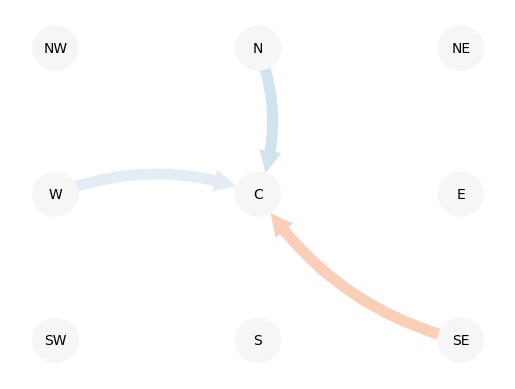

In [13]:
true_stencil_graph, true_stencil_val_matrix = scmg.get_stencil_graph(stencil_matrix=stencil, return_val_matrix=True)

plotting.plot_stencil(true_stencil_graph, true_stencil_val_matrix)

### Gridded Data Generation

With the stencil in hand, we can generate a gridded space-time dataset. The dataset constructs a timeseries for each grid cell in the space such that they are dependent on their neighbors according to the given stencil.

In [34]:
T = 75

dataset = scmg.generate_dataset(T=T, grid_size=grid_size, spatial_coefficients=stencil)
print(f"The dataset has shape (grid_size, grid_size, T): {dataset.shape}")

The dataset has shape (grid_size, grid_size, T): (4, 4, 75)


Dataset generation is itself stochastic. The stencil represents an additive noise model (ANM), such that each grid cell is a function of its neighbors, such as:

$x_{i, t} = f(x_{i, t-1}) + \eta$

for grid cell $x_i$. $\eta$ represents Gaussian noise, with zero mean and 0.1 standard deviation, by default (other values can be passed to scmg.generate_dataset()).

We can visualize the generated space-time grid with the follwing to see a time series for each grid cell:

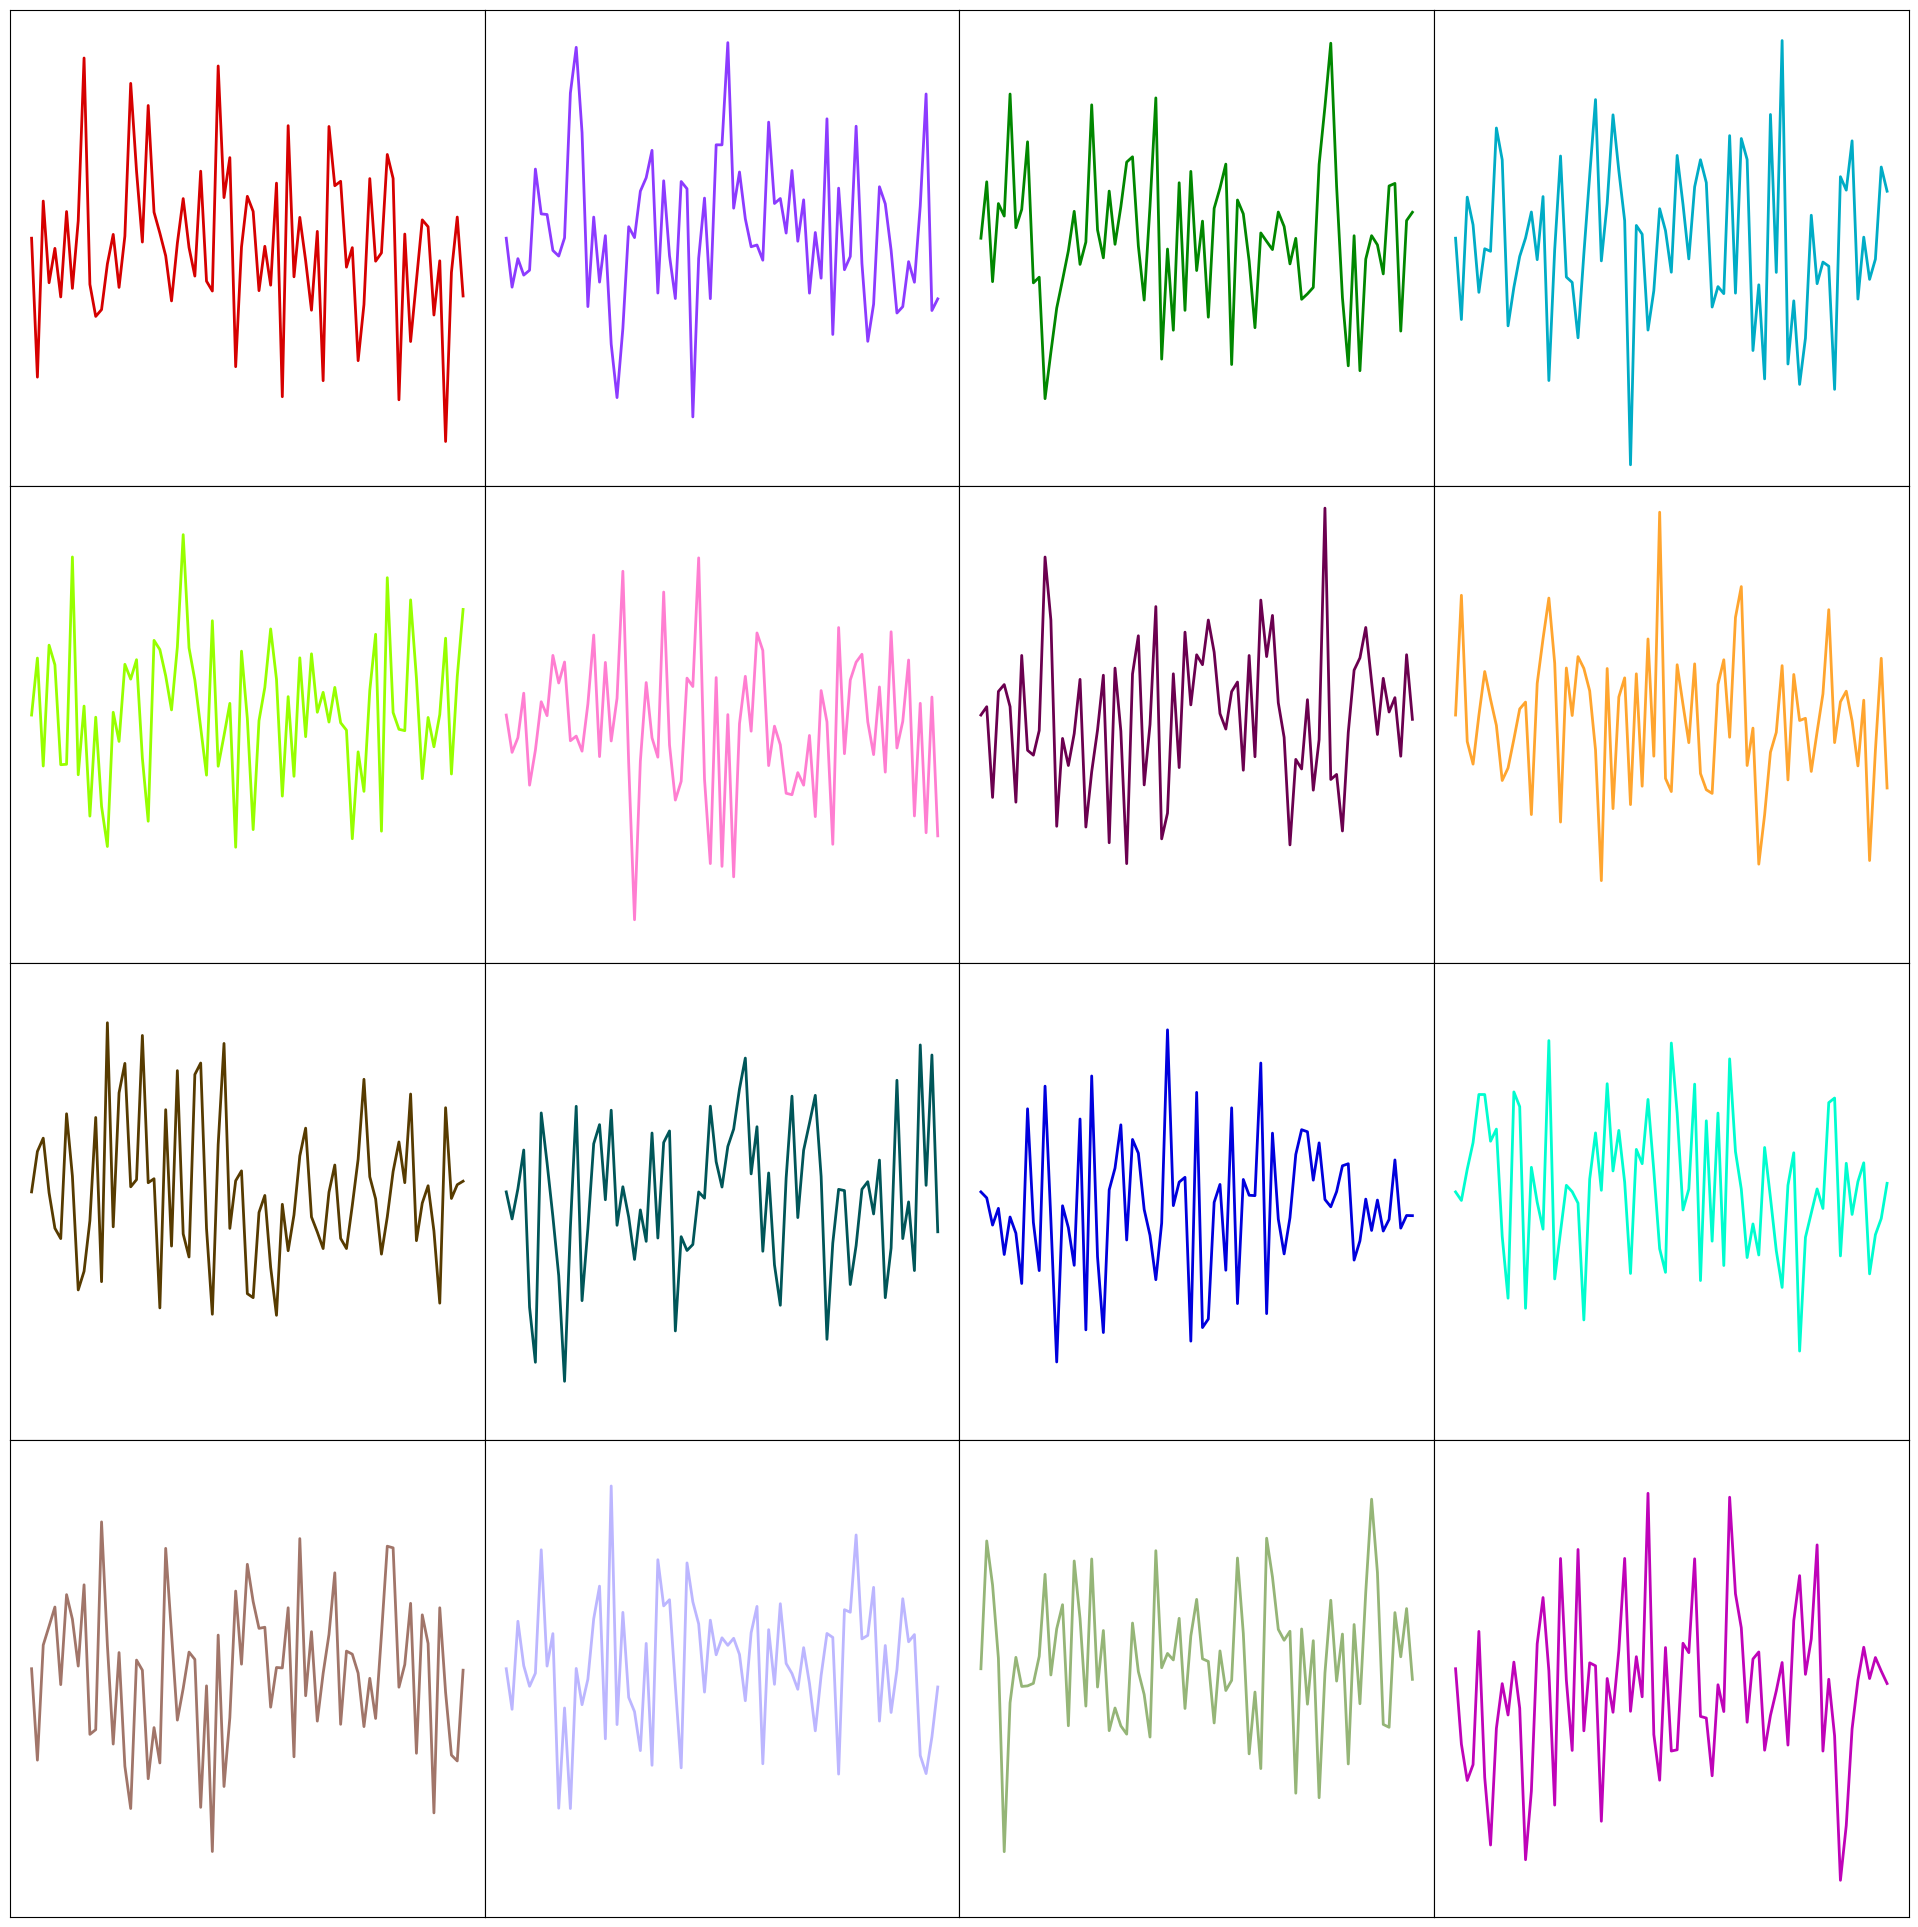

In [35]:
plotting.plot_dataset_timeseries(dataset=dataset)

## Learning the stencil with CaStLe

With the dataset in hand, we can use CaStLe to reconstruct the underlying stencil that generated it.

CaStLe adapts a given causal discovery algorithm for its Parent-Identification Phase (PIP). Here, we will use the PC algorithm developed by Peter Spirtes and Clark Glymour. 

To implement PC, we need to provide a conditional independence test, which PC will use to measure independence and construct a graph. We will use the Tigramite package developed by Jakob Runge to define the partial correlation conditional independence test.

In [36]:
from tigramite.independence_tests.parcorr import ParCorr

parcorr = ParCorr(significance="analytic")

In [37]:
reconstructed_stencil, reconstructed_val_matrix = sf.CaStLe_PC(data=dataset, rows_inverted=True, cond_ind_test=parcorr, pc_alpha=0.1)

Note, the data generation algorithm considers lower row values to be "above" higher ones, so the `rows_inverted` needs to be `True` here. This is different from climate data, in which higher latitude values are "above" lower values, so `rows_inverted` needs to be `False` in that context.

Additionally, PC requires a hyperparameter to regularize the independence tests, which we choose to be `pc_alpha=0.1`.

### Plotting the learned stencil

We can visualize the learned local dynamics by plotting a causal stencil graph with the returned values from CaStLe. The `reconstructed_stencil` variable contains a string-graph (using the data structure used in Tigramite for graphs), which denotes where the links exist or do not. The `reconstructed_val_matrix` variable has the same shape as the stencil, but contains coefficients for each link in the string-graph.

We can use these to plot the graph as follows:

(<Figure size 640x480 with 1 Axes>, <Axes: >)

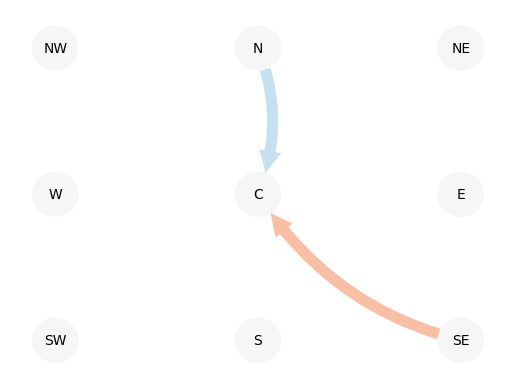

In [38]:
plotting.plot_stencil(reconstructed_stencil, reconstructed_val_matrix)

### Evaluating the discovered stencil
Since we know the exact generating dynamics of the dataset, we can directly compare the true causal graph with the recovered one. To do this, we can compute the $F_1$ Score and the Matthews Correlation Coefficient, two graph-similarity metrics.

In [39]:
F1, P, R, TP, FP, FN, TN = gm.F1_score(true_graph=true_stencil_graph, discovered_graph=reconstructed_stencil)
MCC = gm.matthews_correlation_coefficient(true_graph=true_stencil_graph, discovered_graph=reconstructed_stencil)

print(f"F1 Score = {F1}\nMCC = {MCC}")

F1 Score = 0.8
MCC = 0.8139410298049853


We can improve performance by generating more time samples per time series in the initial dataset.

F1 Score = 1.0
MCC = 1.0


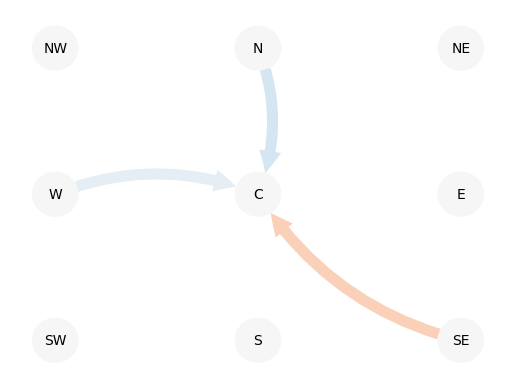

In [43]:
T = 500

dataset = scmg.generate_dataset(T=T, grid_size=grid_size, spatial_coefficients=stencil)

reconstructed_stencil, reconstructed_val_matrix = sf.CaStLe_PC(data=dataset, rows_inverted=True, cond_ind_test=parcorr, pc_alpha=0.1)

plotting.plot_stencil(reconstructed_stencil, reconstructed_val_matrix)

F1, P, R, TP, FP, FN, TN = gm.F1_score(true_graph=true_stencil_graph, discovered_graph=reconstructed_stencil)
MCC = gm.matthews_correlation_coefficient(true_graph=true_stencil_graph, discovered_graph=reconstructed_stencil)

print(f"F1 Score = {F1}\nMCC = {MCC}")